# 1. Data Preparation for Machine Learning in Metabolomics

Data preparation is one of the most critical steps in any machine learning pipeline. In metabolomics, proper data preparation can significantly impact model performance and interpretability. This notebook covers essential data preparation techniques that will serve as the foundation for your machine learning projects.

## Learning Objectives
- Understand the importance of data preparation in machine learning
- Learn how to properly split data into training, validation, and test sets
- Master techniques for handling missing values
- Apply feature engineering and scaling methods
- Address imbalanced dataset challenges

## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Loading and Exploring Data

Let's start by creating a synthetic metabolomics dataset that simulates real-world challenges.

In [2]:
# Generate synthetic metabolomics data
n_samples = 1000
n_features = 50

# Create synthetic data with some class imbalance
X, y = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=30,
    n_redundant=10,
    n_clusters_per_class=1,
    weights=[0.7, 0.3],  # Imbalanced classes
    random_state=42
)

# Create feature names (simulating metabolite names)
feature_names = [f'Metabolite_{i+1:03d}' for i in range(n_features)]

# Convert to DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['Class'] = y

# Introduce some missing values to simulate real data (only in features, not in 'Class')
df_with_missing = df.copy()
feature_mask = np.random.random(df[feature_names].shape) < 0.05  # 5% missing values
df_with_missing.loc[:, feature_names] = df_with_missing.loc[:, feature_names].mask(feature_mask)

print(f"Dataset shape: {df_with_missing.shape}")
print(f"Missing values per column (first 10):")
print(df_with_missing.isnull().sum().head(10))
print(f"\nClass distribution:")
print(df_with_missing['Class'].value_counts())

Dataset shape: (1000, 51)
Missing values per column (first 10):
Metabolite_001    57
Metabolite_002    58
Metabolite_003    53
Metabolite_004    46
Metabolite_005    50
Metabolite_006    39
Metabolite_007    42
Metabolite_008    60
Metabolite_009    41
Metabolite_010    41
dtype: int64

Class distribution:
Class
0    702
1    298
Name: count, dtype: int64


## 2. Data Splitting

Proper data splitting is crucial for unbiased model evaluation. We'll use the standard 80/10/10 split for training, validation, and testing sets respectively. Each set serves a specific purpose:

- **Training set (80%)**: Used to train the model
- **Validation set (10%)**: Used for hyperparameter tuning and model selection
- **Test set (10%)**: Used for final, unbiased evaluation of the best model

In [3]:
# Separate features and target
X = df_with_missing.drop('Class', axis=1)
y = df_with_missing['Class']

# First split: separate test set (10%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

# Second split: separate training and validation sets (80% and 10% of original)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.111, random_state=42, stratify=y_temp  # 0.111 ≈ 10% of original
)

print("Data splitting results:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify class distribution is maintained
print("\nClass distribution across splits:")
print(f"Training: {y_train.value_counts().values}")
print(f"Validation: {y_val.value_counts().values}")
print(f"Test: {y_test.value_counts().values}")

Data splitting results:
Training set: 800 samples (80.0%)
Validation set: 100 samples (10.0%)
Test set: 100 samples (10.0%)

Class distribution across splits:
Training: [562 238]
Validation: [70 30]
Test: [70 30]


## 3. Data Cleaning: Handling Missing Values

Missing values are common in metabolomics data and can significantly impact model performance. We'll explore different imputation strategies:

1. **Remove features with high missing rates** (>50%)
2. **Mean/Median imputation** for numerical features
3. **Analysis of missing value patterns**

In [4]:
# Analyze missing value patterns
missing_percentages = (X_train.isnull().sum() / len(X_train)) * 100

print("Missing value analysis:")
print(f"Features with >50% missing values: {(missing_percentages > 50).sum()}")
print(f"Features with >20% missing values: {(missing_percentages > 20).sum()}")
print(f"Features with any missing values: {(missing_percentages > 0).sum()}")

# # Visualize missing value patterns
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(missing_percentages, bins=20, alpha=0.7, color='skyblue')
# plt.xlabel('Missing Value Percentage')
# plt.ylabel('Number of Features')
# plt.title('Distribution of Missing Values Across Features')

# plt.subplot(1, 2, 2)
# # Show missing pattern for first 20 features
# sns.heatmap(X_train.iloc[:50, :20].isnull(), cbar=True, cmap='viridis')
# plt.title('Missing Value Pattern (First 20 Features, 50 Samples)')
# plt.xlabel('Features')
# plt.ylabel('Samples')

# plt.tight_layout()
# plt.show()

Missing value analysis:
Features with >50% missing values: 0
Features with >20% missing values: 0
Features with any missing values: 50


In [5]:
# Step 1: Remove features with >50% missing values
high_missing_features = missing_percentages[missing_percentages > 50].index
print(f"Removing {len(high_missing_features)} features with >50% missing values")

X_train_clean = X_train.drop(columns=high_missing_features)
X_val_clean = X_val.drop(columns=high_missing_features)
X_test_clean = X_test.drop(columns=high_missing_features)

print(f"Remaining features: {X_train_clean.shape[1]}")

Removing 0 features with >50% missing values
Remaining features: 50


In [6]:
# Step 2: Impute remaining missing values using median imputation
# Note: We fit the imputer only on training data to avoid data leakage

imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_clean),
    columns=X_train_clean.columns,
    index=X_train_clean.index
)

X_val_imputed = pd.DataFrame(
    imputer.transform(X_val_clean),
    columns=X_val_clean.columns,
    index=X_val_clean.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_clean),
    columns=X_test_clean.columns,
    index=X_test_clean.index
)

print("Missing values after imputation:")
print(f"Training set: {X_train_imputed.isnull().sum().sum()}")
print(f"Validation set: {X_val_imputed.isnull().sum().sum()}")
print(f"Test set: {X_test_imputed.isnull().sum().sum()}")

Missing values after imputation:
Training set: 0
Validation set: 0
Test set: 0


## 4. Feature Engineering and Scaling

Feature scaling is crucial for many machine learning algorithms, especially those that use distance measures. We'll demonstrate two common scaling techniques:

1. **Standardization (Z-score normalization)**: Centers data around mean=0, std=1
2. **Min-Max Scaling**: Scales features to a fixed range [0,1]

In [7]:
# Standardization (Z-score scaling)
from sklearn.preprocessing import StandardScaler
scaler_standard = StandardScaler()
X_train_standard = scaler_standard.fit_transform(X_train)
X_test_standard = scaler_standard.transform(X_test)
print('Standardized training data shape:', X_train_standard.shape)

# Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler_minmax = MinMaxScaler()
X_train_minmax = scaler_minmax.fit_transform(X_train)
X_test_minmax = scaler_minmax.transform(X_test)
print('Min-max scaled training data shape:', X_train_minmax.shape)

Standardized training data shape: (800, 50)
Min-max scaled training data shape: (800, 50)


Data shape for visualization: (800, 50)
Target shape: (800,)
Contains NaN: False


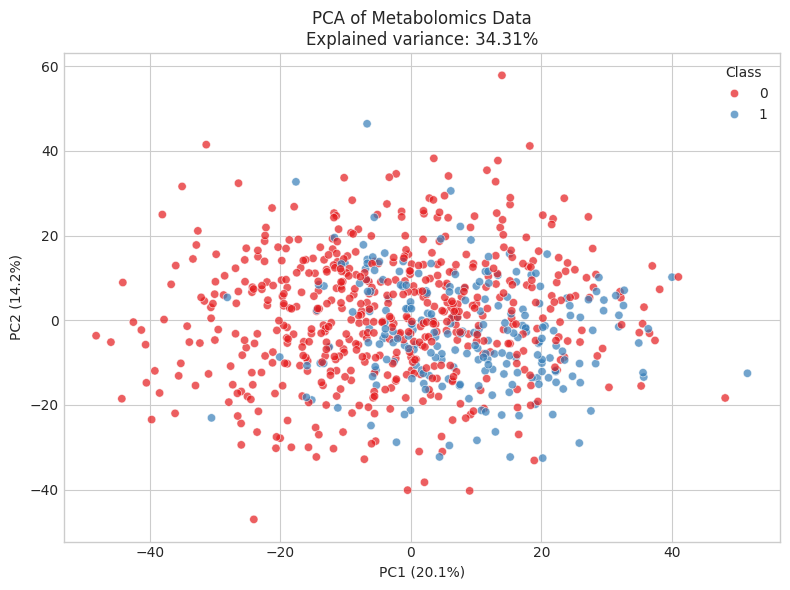

Running t-SNE... this may take a moment


/home/chen/miniconda3/envs/gnps/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
# PCA and t-SNE visualization
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use the imputed and scaled data for visualization (no NaN values)
if 'X_train_imputed' in locals() and X_train_imputed is not None:
    X_vis = X_train_imputed.values if hasattr(X_train_imputed, 'values') else X_train_imputed
elif 'X_train_clean' in locals() and X_train_clean is not None:
    X_vis = X_train_clean.values if hasattr(X_train_clean, 'values') else X_train_clean
else:
    # Fallback: create simple clean data
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_vis = imputer.fit_transform(X_train)

y_vis = y_train if 'y_train' in locals() else y

# Ensure X_vis is 2D numpy array and has no NaN values
if hasattr(X_vis, 'values'):
    X_vis = X_vis.values
if len(X_vis.shape) == 1:
    X_vis = X_vis.reshape(-1, 1)

# Double-check for NaN values and handle them
if np.isnan(X_vis).any():
    print("Found NaN values, applying mean imputation...")
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X_vis = imputer.fit_transform(X_vis)

print(f"Data shape for visualization: {X_vis.shape}")
print(f"Target shape: {y_vis.shape}")
print(f"Contains NaN: {np.isnan(X_vis).any()}")

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_vis)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_vis, palette='Set1', alpha=0.7)
plt.title(f'PCA of Metabolomics Data\nExplained variance: {pca.explained_variance_ratio_.sum():.2%}')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

# t-SNE (can be slow on large datasets)
print("Running t-SNE... this may take a moment")
# Limit data size for t-SNE if too large
if len(X_vis) > 1000:
    indices = np.random.choice(len(X_vis), 1000, replace=False)
    X_tsne_input = X_vis[indices]
    y_tsne_input = y_vis.iloc[indices] if hasattr(y_vis, 'iloc') else y_vis[indices]
else:
    X_tsne_input = X_vis
    y_tsne_input = y_vis

tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_tsne_input)//4), n_iter=1000)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_tsne_input, palette='Set1', alpha=0.7)
plt.title('t-SNE of Metabolomics Data')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Class')
plt.tight_layout()
plt.show()

print("Dimensionality reduction completed successfully!")

### Why Use PCA and t-SNE for Visualization?
PCA and t-SNE are dimensionality reduction techniques that help visualize high-dimensional metabolomics data. PCA shows the main axes of variance, while t-SNE can reveal clusters and non-linear relationships. Use these plots to check if classes are separable and to spot outliers or patterns in your data.

## Dimensionality Reduction: PCA and t-SNE
Dimensionality reduction techniques like PCA and t-SNE help visualize high-dimensional metabolomics data. PCA captures the main axes of variance, while t-SNE is useful for visualizing clusters and non-linear relationships.

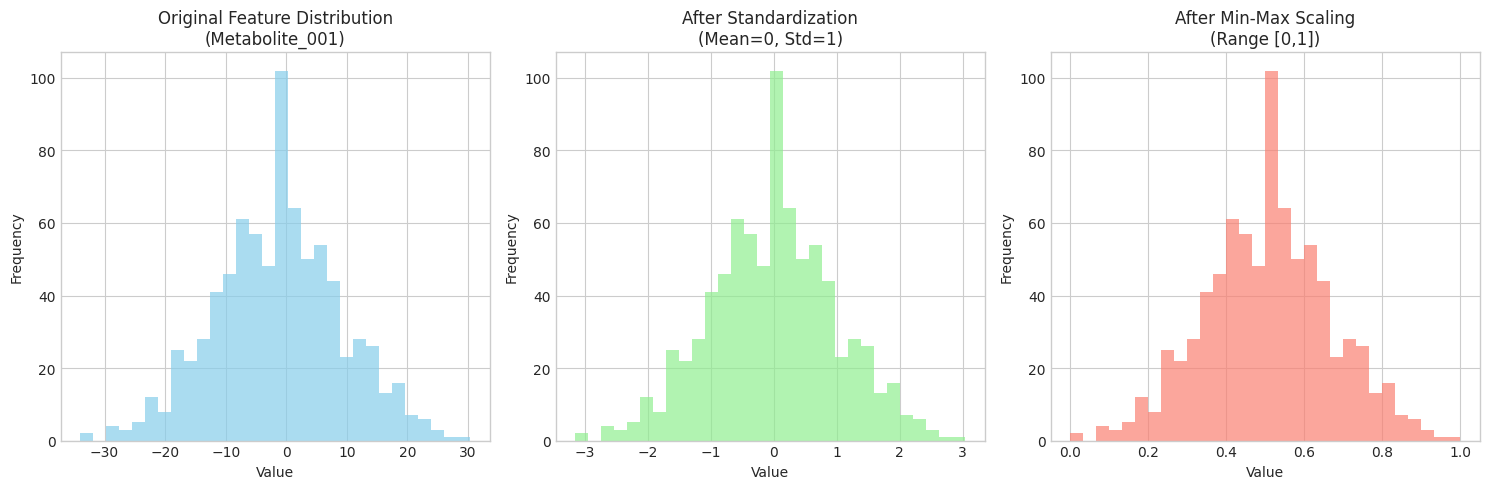

Scaling comparison for first feature:
Original - Mean: -1.267, Std: 10.411
Standardized - Mean: 0.000, Std: 1.001
Min-Max - Min: 0.000, Max: 1.000


In [ ]:
# Before scaling - examine feature distributions
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(X_train_imputed.iloc[:, 0], bins=30, alpha=0.7, color='skyblue')
plt.title('Original Feature Distribution\n(Metabolite_001)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Apply Standardization
scaler_standard = StandardScaler()
X_train_standard = pd.DataFrame(
    scaler_standard.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

plt.subplot(1, 3, 2)
plt.hist(X_train_standard.iloc[:, 0], bins=30, alpha=0.7, color='lightgreen')
plt.title('After Standardization\n(Mean=0, Std=1)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Apply Min-Max Scaling
scaler_minmax = MinMaxScaler()
X_train_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

plt.subplot(1, 3, 3)
plt.hist(X_train_minmax.iloc[:, 0], bins=30, alpha=0.7, color='salmon')
plt.title('After Min-Max Scaling\n(Range [0,1])')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Print statistics
print("Scaling comparison for first feature:")
print(f"Original - Mean: {X_train_imputed.iloc[:, 0].mean():.3f}, Std: {X_train_imputed.iloc[:, 0].std():.3f}")
print(f"Standardized - Mean: {X_train_standard.iloc[:, 0].mean():.3f}, Std: {X_train_standard.iloc[:, 0].std():.3f}")
print(f"Min-Max - Min: {X_train_minmax.iloc[:, 0].min():.3f}, Max: {X_train_minmax.iloc[:, 0].max():.3f}")

## 5. Handling Imbalanced Datasets

Imbalanced datasets are common in metabolomics where one class (e.g., disease) may be less frequent than another (healthy controls). This can lead to biased models that perform poorly on the minority class. We'll explore two main approaches:

1. **Undersampling**: Reduce the majority class
2. **Oversampling (SMOTE)**: Generate synthetic examples for the minority class

Original class distribution:
Class 0: 562 samples
Class 1: 238 samples
Imbalance ratio: 2.36:1


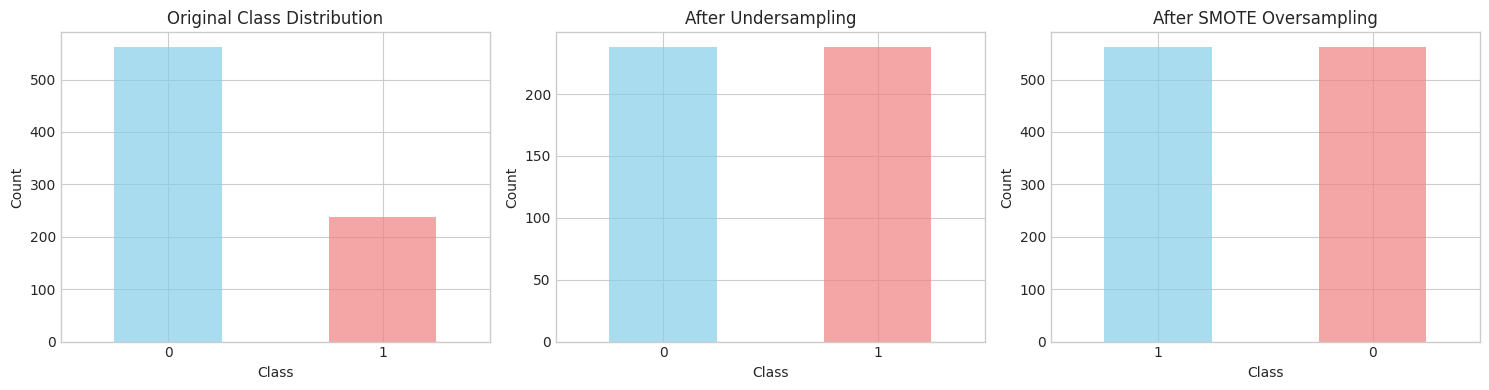


Dataset sizes after balancing:
Original: 800 samples
Undersampled: 476 samples
SMOTE: 1124 samples


In [ ]:
# Analyze class imbalance
class_counts = y_train.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Original class distribution:")
print(f"Class 0: {class_counts[0]} samples")
print(f"Class 1: {class_counts[1]} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Visualize class distribution
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
y_train.value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Apply undersampling
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_standard, y_train)

plt.subplot(1, 3, 2)
pd.Series(y_train_under).value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('After Undersampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_standard, y_train)

plt.subplot(1, 3, 3)
pd.Series(y_train_smote).value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'], alpha=0.7)
plt.title('After SMOTE Oversampling')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

print(f"\nDataset sizes after balancing:")
print(f"Original: {len(y_train)} samples")
print(f"Undersampled: {len(y_train_under)} samples")
print(f"SMOTE: {len(y_train_smote)} samples")

**Interpreting the Class Balancing Results Above**
The bar plots show how class distributions change after undersampling and SMOTE. Undersampling reduces the majority class, while SMOTE generates synthetic samples for the minority class. Balanced datasets help models learn equally from both classes, improving performance on the minority class.

## 6. Final Data Preparation Pipeline

Let's create a complete data preparation pipeline that we can use in subsequent notebooks.

In [ ]:
def prepare_data_pipeline(X_train, X_val, X_test, y_train, 
                         missing_threshold=0.5, 
                         scaling_method='standard',
                         balance_method=None):
    """
    Complete data preparation pipeline.
    
    Parameters:
    -----------
    X_train, X_val, X_test : DataFrames
        Feature matrices for train, validation, and test sets
    y_train : Series
        Training labels
    missing_threshold : float
        Threshold for removing features with missing values
    scaling_method : str
        'standard' or 'minmax'
    balance_method : str or None
        'undersample', 'smote', or None
    
    Returns:
    --------
    Processed datasets and fitted preprocessors
    """
    
    # 1. Remove features with high missing rates
    missing_percentages = (X_train.isnull().sum() / len(X_train))
    features_to_keep = missing_percentages[missing_percentages <= missing_threshold].index
    
    X_train_clean = X_train[features_to_keep]
    X_val_clean = X_val[features_to_keep]
    X_test_clean = X_test[features_to_keep]
    
    print(f"Kept {len(features_to_keep)} features after removing high-missing features")
    
    # 2. Impute missing values
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_clean),
        columns=X_train_clean.columns,
        index=X_train_clean.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val_clean),
        columns=X_val_clean.columns,
        index=X_val_clean.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test_clean),
        columns=X_test_clean.columns,
        index=X_test_clean.index
    )
    
    # 3. Scale features
    if scaling_method == 'standard':
        scaler = StandardScaler()
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("scaling_method must be 'standard' or 'minmax'")
    
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=X_train_imputed.columns,
        index=X_train_imputed.index
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val_imputed),
        columns=X_val_imputed.columns,
        index=X_val_imputed.index
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imputed),
        columns=X_test_imputed.columns,
        index=X_test_imputed.index
    )
    
    # 4. Handle class imbalance (only on training set)
    y_train_balanced = y_train.copy()
    if balance_method == 'undersample':
        undersampler = RandomUnderSampler(random_state=42)
        X_train_scaled, y_train_balanced = undersampler.fit_resample(X_train_scaled, y_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_to_keep)
        print(f"Applied undersampling: {len(y_train_balanced)} samples")
        
    elif balance_method == 'smote':
        smote = SMOTE(random_state=42)
        X_train_scaled, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=features_to_keep)
        print(f"Applied SMOTE: {len(y_train_balanced)} samples")
    
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train_balanced,
        'y_val': y_val,
        'y_test': y_test,
        'preprocessors': {
            'imputer': imputer,
            'scaler': scaler,
            'features_kept': features_to_keep
        }
    }

# Apply the pipeline
processed_data = prepare_data_pipeline(
    X_train, X_val, X_test, y_train,
    missing_threshold=0.5,
    scaling_method='standard',
    balance_method='smote'
)

print("\nData preparation pipeline completed!")
print(f"Final training set shape: {processed_data['X_train'].shape}")
print(f"Final validation set shape: {processed_data['X_val'].shape}")
print(f"Final test set shape: {processed_data['X_test'].shape}")

Kept 50 features after removing high-missing features
Applied SMOTE: 1124 samples

Data preparation pipeline completed!
Final training set shape: (1124, 50)
Final validation set shape: (100, 50)
Final test set shape: (100, 50)
Applied SMOTE: 1124 samples

Data preparation pipeline completed!
Final training set shape: (1124, 50)
Final validation set shape: (100, 50)
Final test set shape: (100, 50)


## Summary

In this notebook, we covered the essential steps of data preparation for machine learning in metabolomics:

1. **Data Loading and Exploration**: Understanding your dataset structure and characteristics
2. **Data Splitting**: Properly dividing data into training (80%), validation (10%), and test (10%) sets
3. **Missing Value Handling**: Removing high-missing features and imputing remaining values
4. **Feature Scaling**: Standardization and Min-Max scaling for algorithm compatibility
5. **Imbalanced Data**: Techniques to handle class imbalance using undersampling and SMOTE
6. **Pipeline Creation**: Building a reusable data preparation pipeline

### Key Takeaways:
- Always fit preprocessors on training data only to avoid data leakage
- Choose imputation and scaling strategies based on your data characteristics
- Consider class imbalance and its impact on model performance
- Create reproducible pipelines for consistent preprocessing

### Next Steps:
In the next notebook, we'll use this prepared data to train and tune machine learning models, building on the foundation we've established here.